<a href="https://colab.research.google.com/github/JiseokSeo/Kaggle_Competition/blob/main/driver_EDA%26visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA, visualize

In [ ]:
!pip install missingno

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV

%matplotlib inline

In [ ]:
path = './'
train = pd.read_csv(path + 'train.csv', index_col='id')
test = pd.read_csv(path + 'test.csv', index_col='id')
submission = pd.read_csv(path + 'sample_submission.csv', index_col='id')

In [ ]:
##함수들

## 막대그래프 비율 표시
def write_percent(ax, df):
    '''
    sns.countplot에서, 각 도형 객체를 순회하며 막대 그래프 상단에 비율을 표시합니다
    '''
    total_size = len(df)
    
    for patch in ax.patches:
        h = patch.get_height()
        w = patch.get_width()
        left_coord = patch.get_x()
        percent = h / total_size * 100
        
        ax.text(left_coord + w/2,
                h + total_size*0.001,
                '{:1.1f}%'.format(percent),
                ha='center')
        
        
## 피처요약표
def resumetable(df:pd.DataFrame):
    '''
    df를 한눈에 볼 수 있게 피처요약표를 만듭니다
    각 competition 마다 df 형식이 다르므로, 재활용을 원장하지 않습니다
    '''
    print(f'shape: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['dtype'])
    summary['num of NaN'] = (df == -1).sum().values
    summary['nunique'] = df.nunique().values
    summary['kind'] = None
    
    for col in df.columns:
        if 'bin' in col or col == 'target':
            summary.loc[col, 'kind'] = 'binary'
        elif 'cat' in col:
            summary.loc[col, 'kind'] = 'categorical'
        elif df[col].dtype == float:
            summary.loc[col, 'kind'] = 'float'
        elif df[col].dtype == 'int64':
            summary.loc[col, 'kind'] = 'ordinal'
            
    return summary


def plot_target_ratio_by_features(df:pd.DataFrame, target:str, features, num_cols=1, size:tuple=(12, 18)):
    '''
    이산형 피처에서, 고윳값별 타깃값 비율을 그리는 함수
    '''
    mpl.rc('font', size=9)                           
    plt.figure(figsize=size)                                              # 전체 크기 설정
    grid = gridspec.GridSpec(len(features)//num_cols, num_cols)           # 서브플롯 배치
    plt.subplots_adjust(wspace=0.3, hspace=0.3)                           # 상하간격 설정
    
    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])
        sns.barplot(x=feature, y=target, data=df, ax=ax, palette='Set2')
        
        
    
def plot_target_ratio_by_features_float(df:pd.DataFrame, target:str, features, num_cols=1,  num_cuts=5, size:tuple=(12, 18)):
    '''
    연속형 피처에서, 연속값 피처를 N개 구간으로 나눠 이산형으로 표현하여 타깃값 비율을 그리는 함수
    '''
    df_copy = df.copy()
    
    mpl.rc('font', size=9)
    plt.figure(figsize=size)
    grid = gridspec.GridSpec(len(features)//num_cols, num_cols)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    for idx, feature in enumerate(features):
        df_copy[feature] = pd.cut(df_copy[feature], num_cuts)
        ax = plt.subplot(grid[idx])
        sns.barplot(x=feature, y=target, data=df_copy, ax=ax, palette='Set2')
        ax.tick_params(axis='x', labelrotation=10)
        
        
def corr_heatmap(df:pd.DataFrame, features, size:tuple=(10, 8)):
    '''
    연속형 피처의 상관관계를 히트맵으로 나타냅니다
    '''
    df_copy = df.copy()
    
    plt.figure(figsize=size)
    cont_corr = df_copy.dropna()[features].corr()
    sns.heatmap(cont_corr, annot=True, cmap='OrRd')

In [ ]:
## 탐색적 데이터 분석
train.shape, test.shape

#데이터랑 피처 수가 좀 많다

((595212, 58), (892816, 57))

In [ ]:
train.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [ ]:
test.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
0,0,1,8,1,0,0,1,0,0,0,...,1,1,1,12,0,1,1,0,0,1
1,4,2,5,1,0,0,0,0,1,0,...,2,0,3,10,0,0,1,1,0,1
2,5,1,3,0,0,0,0,0,1,0,...,4,0,2,4,0,0,0,0,0,0
3,0,1,6,0,0,1,0,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,5,1,7,0,0,0,0,0,1,0,...,4,0,0,4,0,1,1,0,0,1


In [ ]:
submission.head()

,target
id,
0,0.0364
1,0.0364
2,0.0364
3,0.0364
4,0.0364


In [ ]:
train.info()
# 피처명에 다양한 메타정보가 포함되어있다!
# 그러나 피처명 자체는 비식별처리 되어있어 의미를 알 수 없다

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595212 entries, 7 to 1488027
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17

<AxesSubplot:>

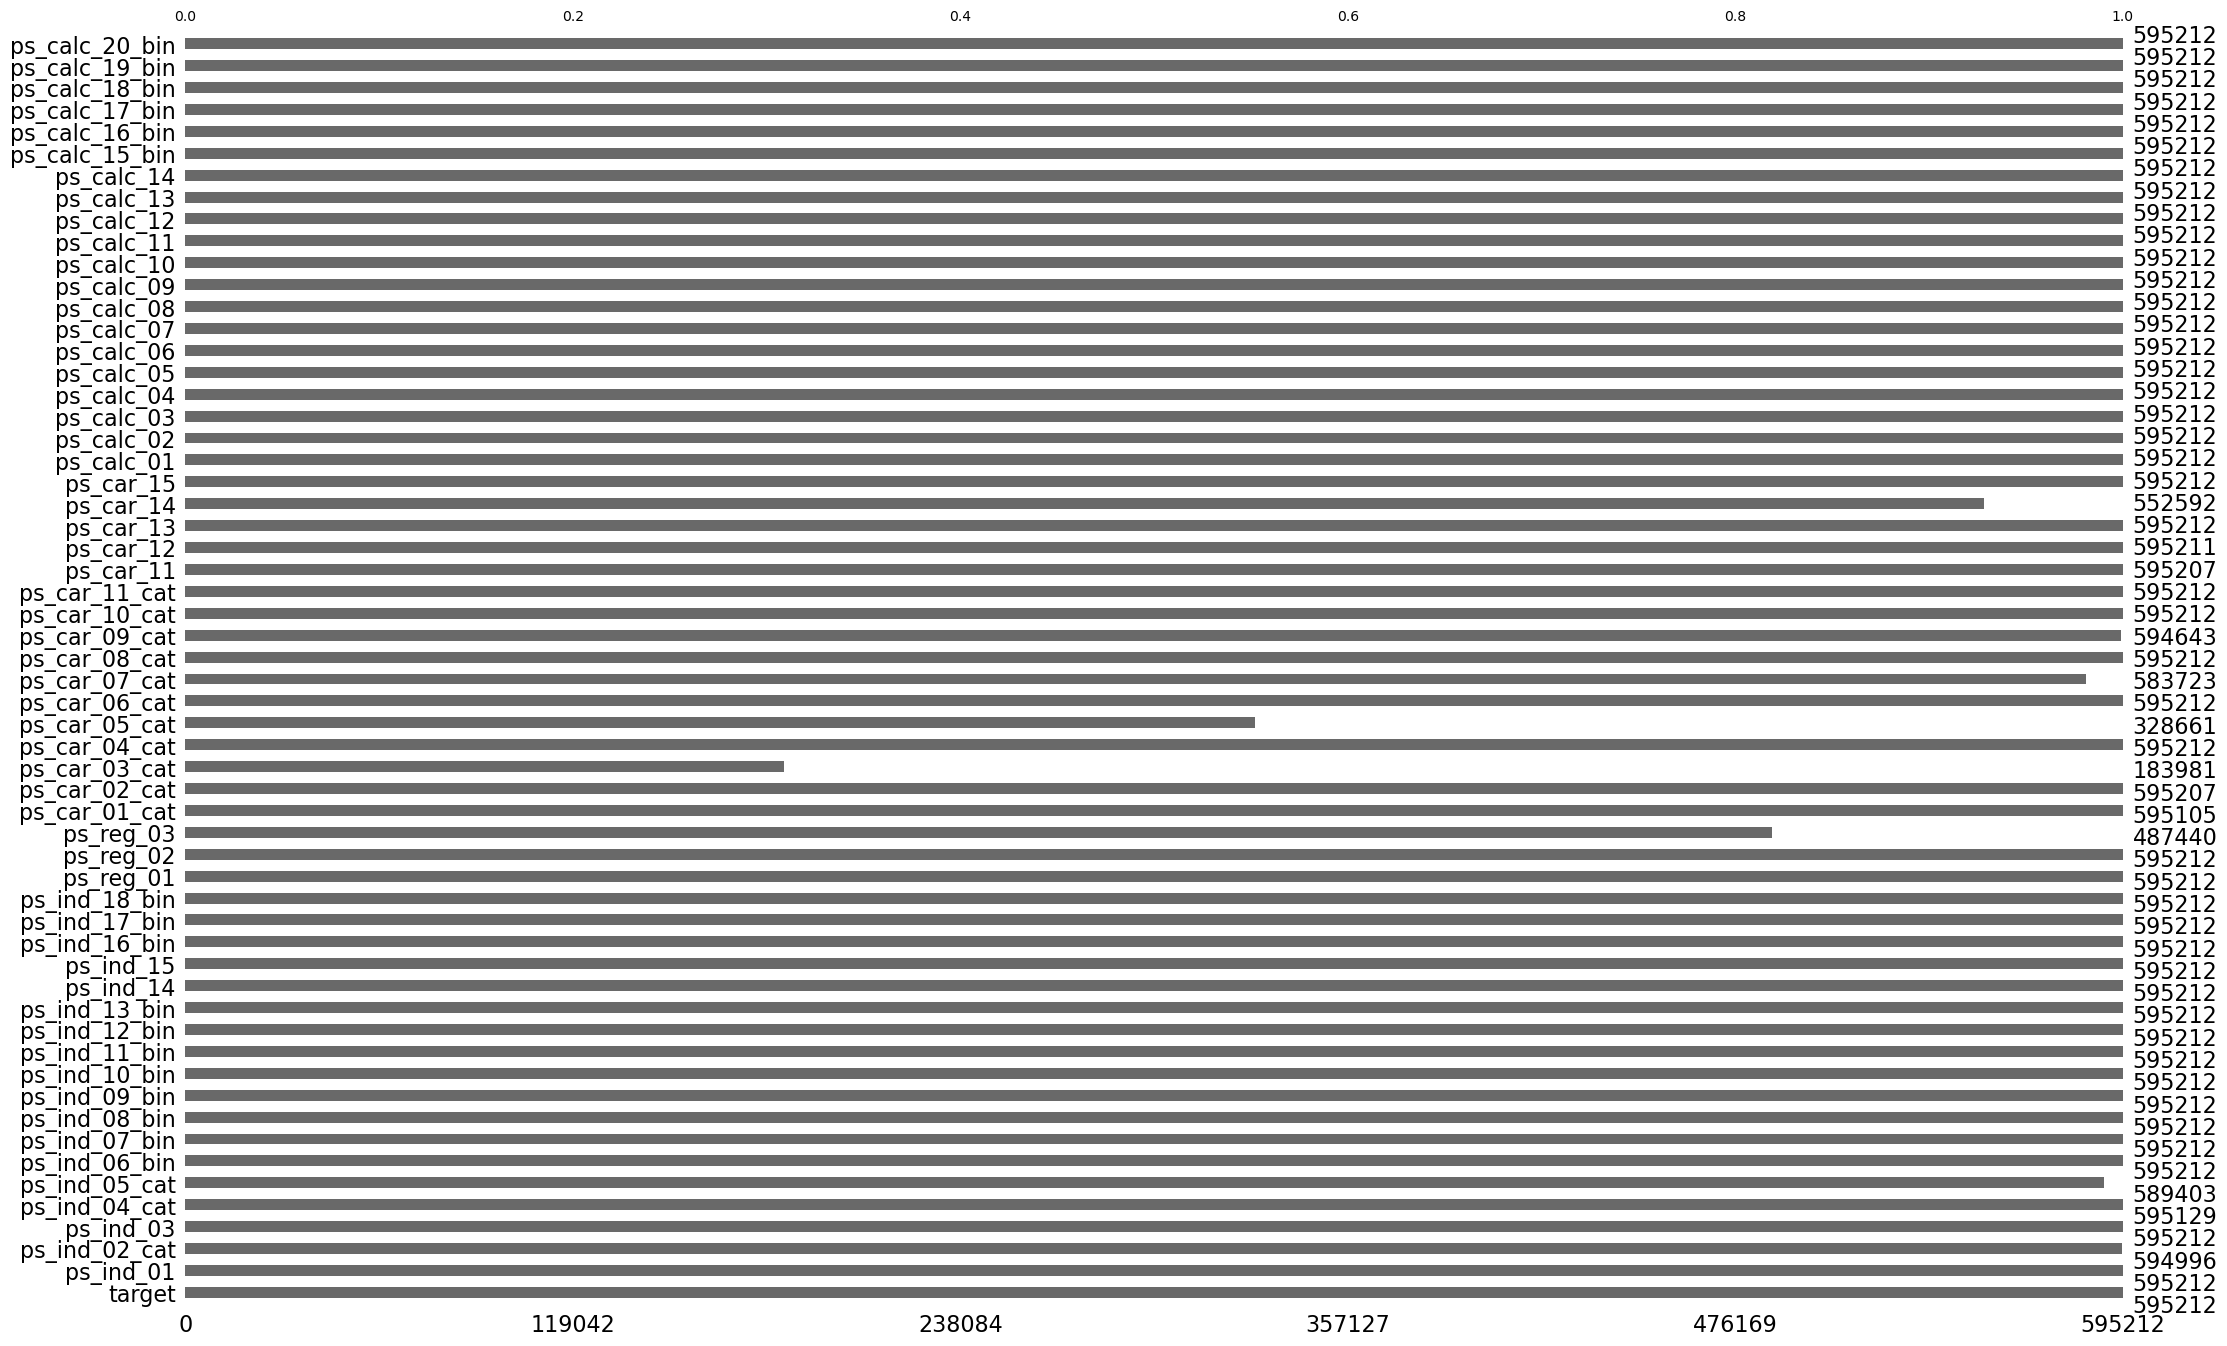

In [ ]:
train_copy = train.copy()
test_copy = test.copy()

msno.bar(train_copy.replace(-1, np.nan))
# 결측값 다수 존재

In [ ]:
summary = resumetable(train)
summary

shape: (595212, 58)


,dtype,num of NaN,nunique,kind
target,int64,0,2,binary
ps_ind_01,int64,0,8,ordinal
ps_ind_02_cat,int64,216,5,categorical
ps_ind_03,int64,0,12,ordinal
ps_ind_04_cat,int64,83,3,categorical
ps_ind_05_cat,int64,5809,8,categorical
ps_ind_06_bin,int64,0,2,binary
ps_ind_07_bin,int64,0,2,binary
ps_ind_08_bin,int64,0,2,binary
ps_ind_09_bin,int64,0,2,binary


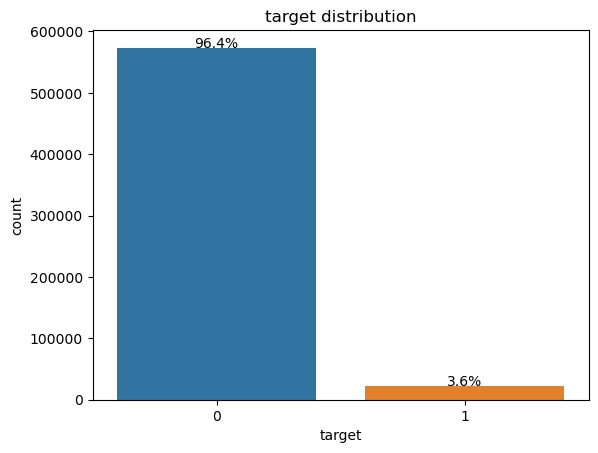

In [ ]:
## 데이터 시각화
### 타깃값 분포

ax = sns.countplot(x='target', data=train)
write_percent(ax, train)
ax.set_title('target distribution');
# 타깃값이 불균형한 컴페티션이므로, 타깃값 1(적은 비율 타겟)을 예측하는 것이 중요함
# 따라서 타깃값 1이 많은 피처는 선택하고, 적은 피처는 버려야 함 => 고윳값마다 타깃값 비율이 달라야 모델링에 좋음
# 타깃값 1 비율이 통계적으로 유효한 피처를 선택 => 신뢰구간으로 판단

# ==> 고윳값별 타깃값 1 비율이 충분히 차이나고, 신뢰구간도 작은 피처를 선택해야 함!!

In [ ]:
## 이진분류 피처의 경우

bin_features = summary[summary['kind'] == 'binary'].index
bin_features

Index(['target', 'ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin',
       'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin',
       'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin',
       'ps_calc_15_bin', 'ps_calc_16_bin', 'ps_calc_17_bin', 'ps_calc_18_bin',
       'ps_calc_19_bin', 'ps_calc_20_bin'],
      dtype='object')

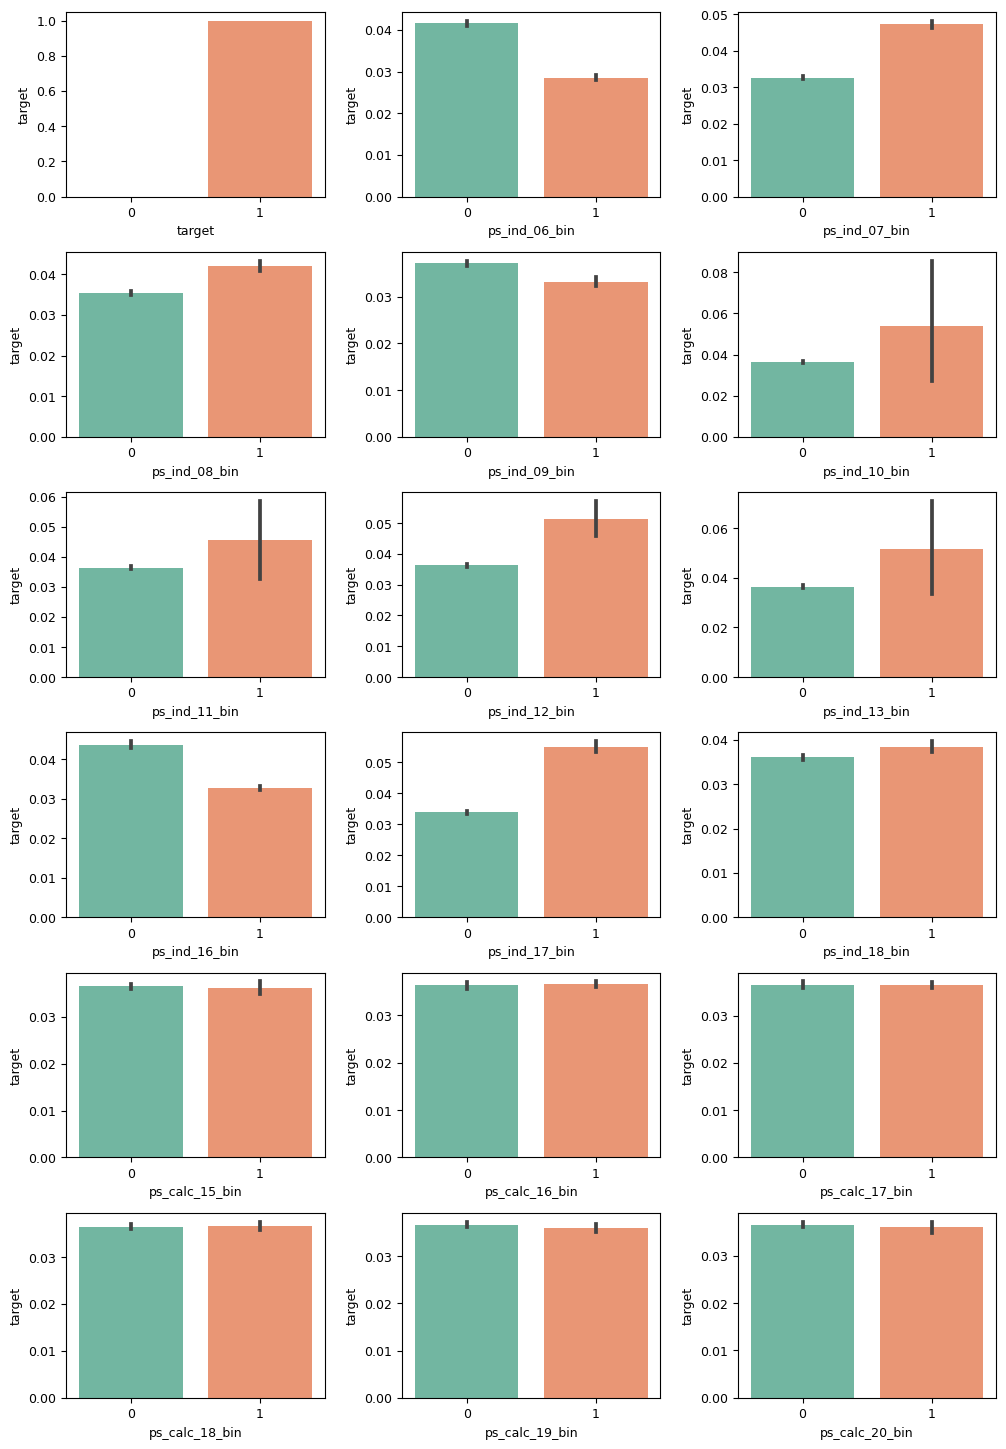

In [ ]:
plot_target_ratio_by_features(df=train,
                              target='target',
                              features=bin_features,
                              num_cols=3)
# 제거 => ps_ind_10 ~ ps_ind_13, ps_calc_15 ~ ps_calc_20

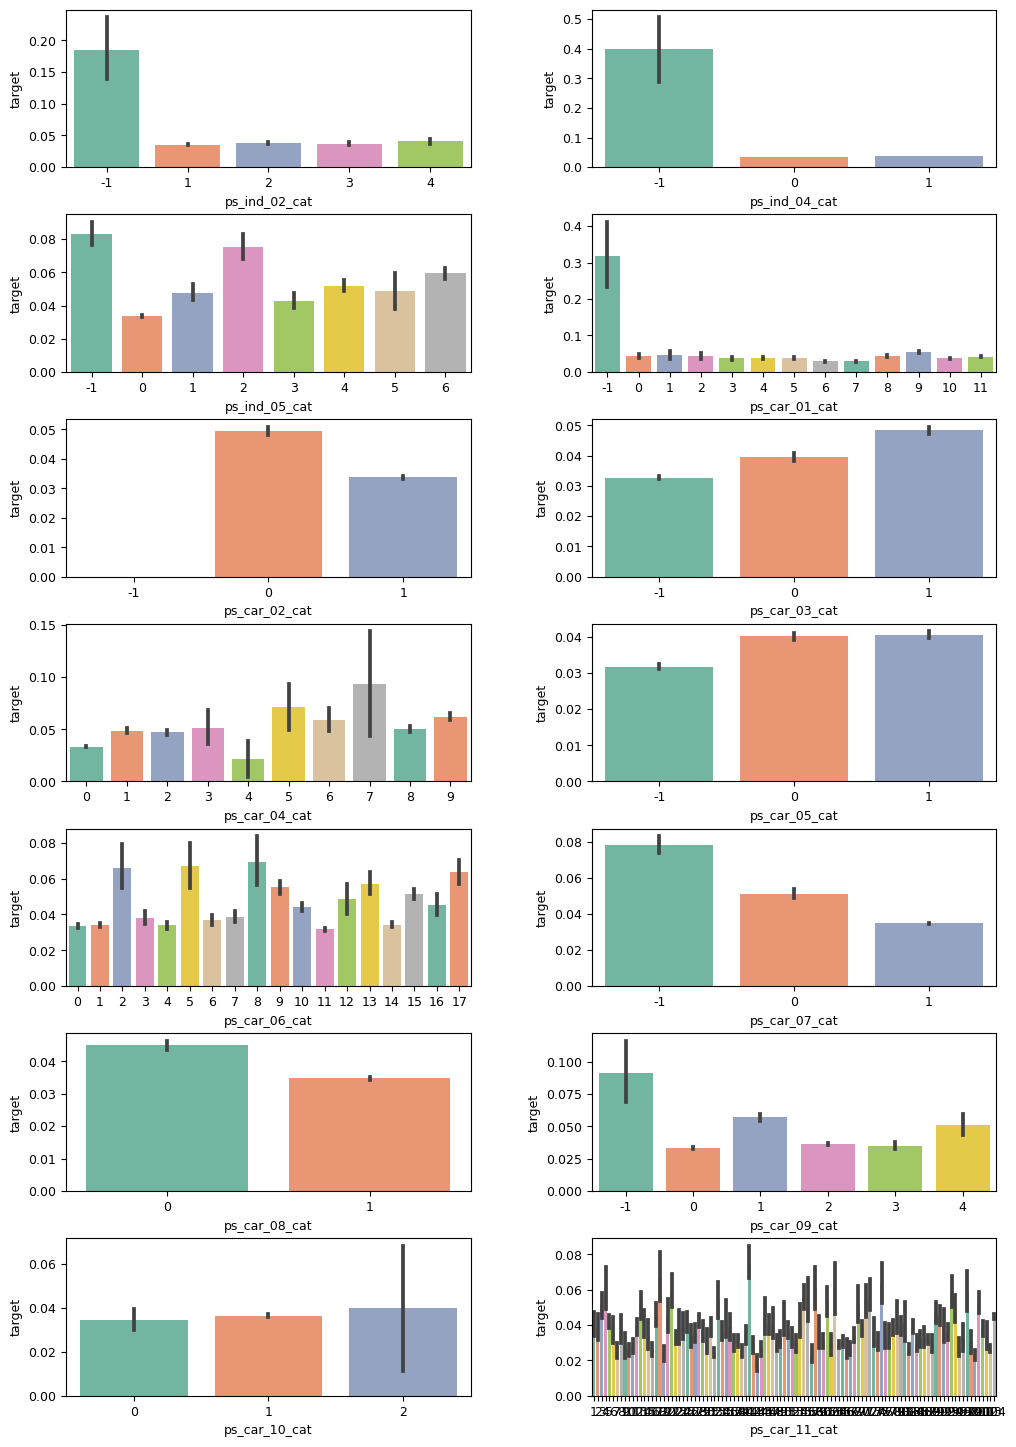

In [ ]:
## 명목형 피처의 경우
categorical_features = summary[summary['kind'] == 'categorical'].index

plot_target_ratio_by_features(df=train,
                             target='target',
                             features=categorical_features,
                              num_cols=2)
# 제거하지 않음

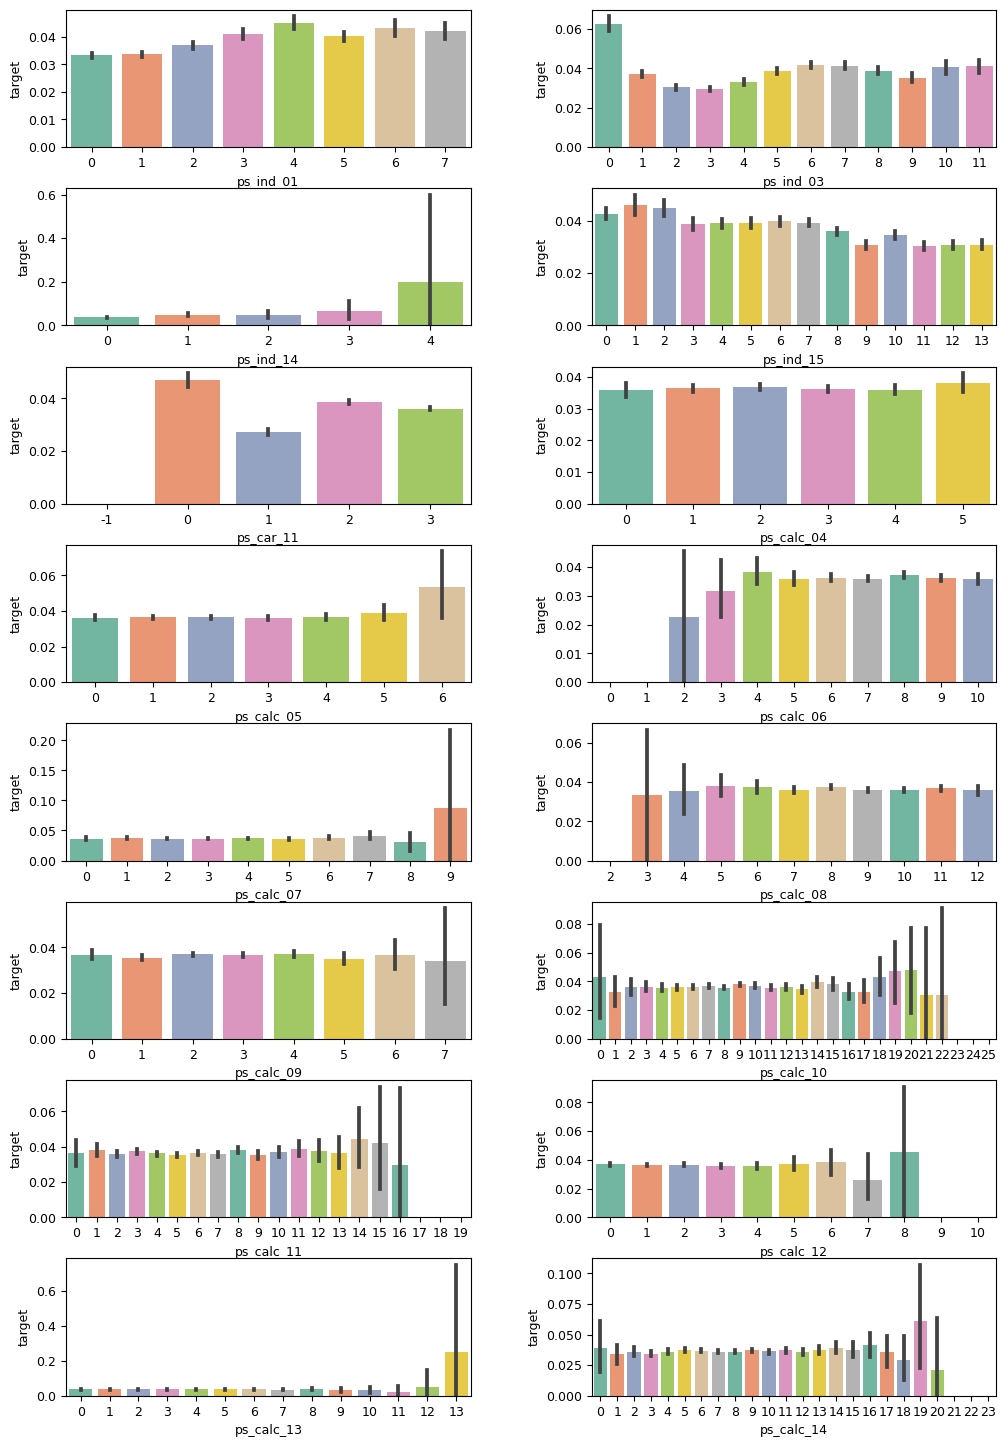

In [ ]:
## 순서형 피처의 경우
ordinal_features = summary[summary['kind']=='ordinal'].index

plot_target_ratio_by_features(train, 'target', ordinal_features, 2, (12, 18))
# 제거 => ps_ind_14 / pa_calc_o4 ~ 14

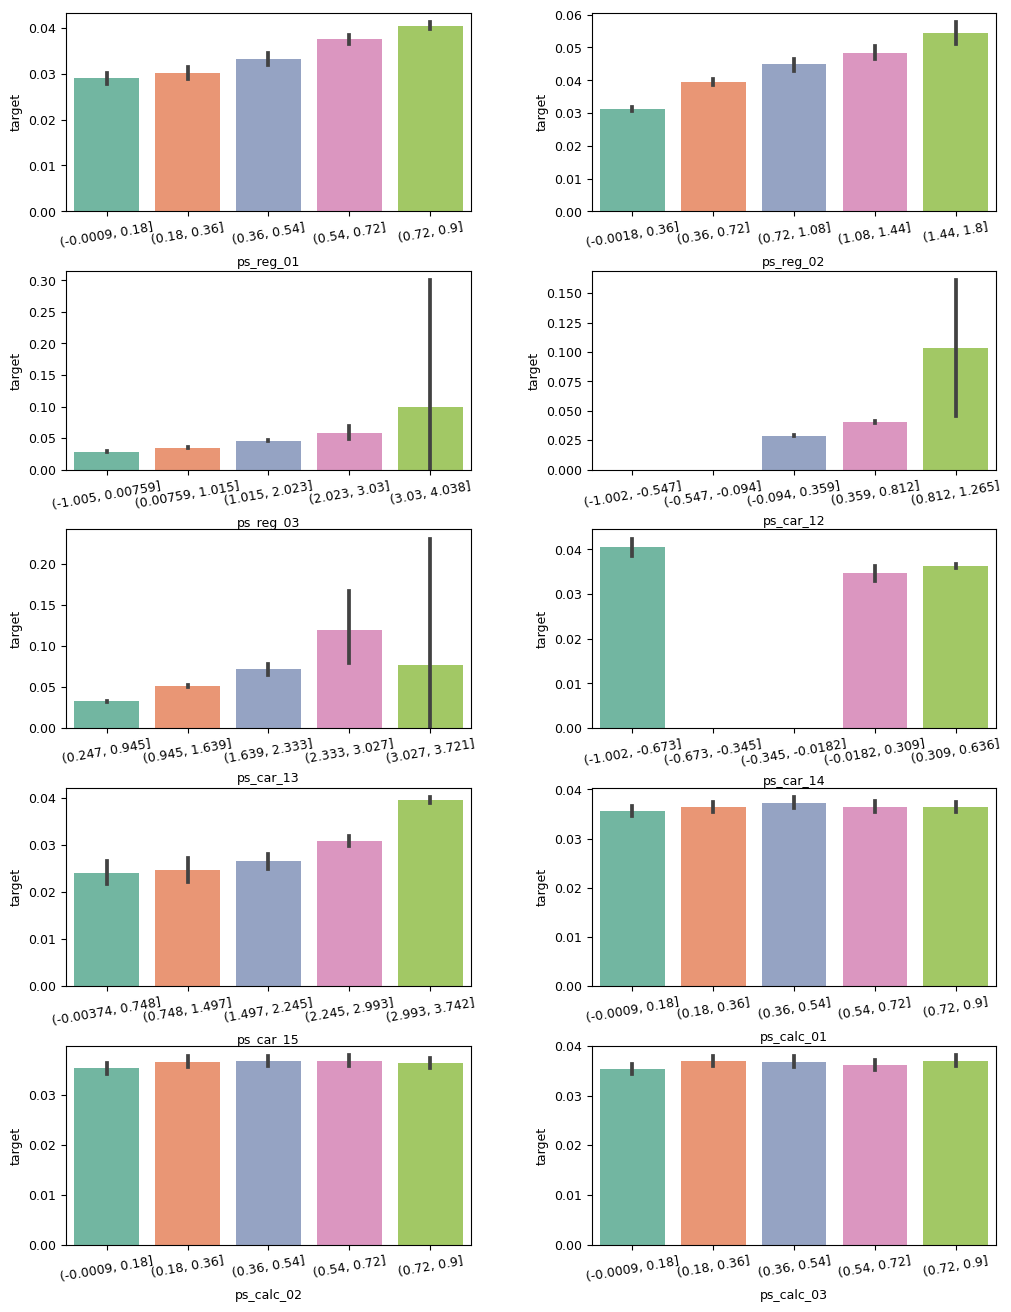

In [ ]:
## 연속형 피처의 경우, 고윳값이 매우 많기 때문에 명목화시킨 후 확인
cont_features = summary[summary['kind'] == 'float'].index

plot_target_ratio_by_features_float(df=train,
                                   target='target',
                                   features=cont_features,
                                   num_cols=2,
                                   num_cuts=5,
                                   size=(12, 16))
# 제거 => ps_calc_01 ~ 03

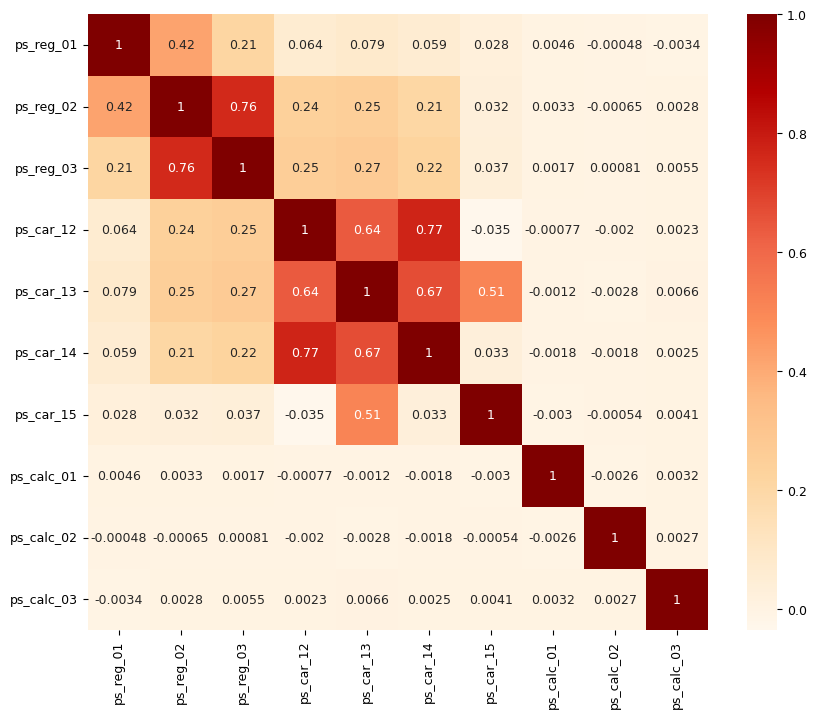

In [ ]:
## 연속형피처 상관관계 파악
corr_heatmap(df=train_copy.replace(-1, np.NaN), features=cont_features, size=(10,8))
# 제거 => ps_car_14